# Frame1-from-frame2 with ViT clean + fusion heads


In [ ]:
from pathlib import Path
from collections import defaultdict
import random
import re
import math

import cv2
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F

DATA_ROOT = Path('.')
IMAGES_DIR = DATA_ROOT / 'images'
MASKS_DIR = DATA_ROOT / 'masks'

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

TRAIN_BATCH_SIZE = 4
VAL_BATCH_SIZE = 4
NUM_WORKERS = 0
NUM_EPOCHS = 30
LEARNING_RATE = 1e-3
AUGMENT_TRAIN = False

# ViT-like model sizes
PATCH = 16
CLEAN_EMBED_DIM = 64
CLEAN_DEPTH = 6
CLEAN_HEADS = 4
CLEAN_MLP_RATIO = 4

FUSION_BASE = 64
FUSION_HEADS = 4
FUSION_WIN = 8
FUSION_BLOCKS = 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
PIN_MEMORY = device.type == 'cuda'

print('Using device:', device)


Using device: cuda


In [2]:
FILENAME_PATTERN = re.compile(r"^(?P<prefix>[A-Za-z0-9]{6})(?P<frame>\d+)_")


def parse_frame_key(path: Path):
    match = FILENAME_PATTERN.match(path.stem)
    if not match:
        raise ValueError(f"Unexpected filename: {path.name}")
    return match.group("prefix"), int(match.group("frame"))


def load_gray(path: Path) -> np.ndarray:
    image = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(path)
    return image


def collect_frame_pairs(images_dir: Path, masks_dir: Path) -> pd.DataFrame:
    grouped = defaultdict(list)
    for img_path in images_dir.glob("*.png"):
        try:
            prefix, frame_idx = parse_frame_key(img_path)
        except ValueError:
            continue
        grouped[prefix].append((frame_idx, img_path))

    rows = []
    for prefix, frames in grouped.items():
        frames.sort(key=lambda x: x[0])
        for (idx_prev, path_prev), (_, path_next) in zip(frames, frames[1:]):
            mask_prev = masks_dir / path_prev.name
            if not mask_prev.exists():
                continue
            rows.append(
                {
                    "frame1": path_prev,
                    "frame2": path_next,
                    "mask1": mask_prev,
                    "sequence": prefix,
                    "frame_idx": idx_prev,
                }
            )
    return pd.DataFrame(rows)


pairs_df = collect_frame_pairs(IMAGES_DIR, MASKS_DIR)
print(f"Total pairs: {len(pairs_df)} from {pairs_df['sequence'].nunique()} sequences")
if len(pairs_df) == 0:
    raise RuntimeError("No frame pairs found. Confirm IMAGES_DIR and MASKS_DIR are populated.")
pairs_df.head()

Total pairs: 6337 from 87 sequences


,frame1,frame2,mask1,sequence,frame_idx
0,images\ns050a196_resized_512.png,images\ns050a198_resized_512.png,masks\ns050a196_resized_512.png,ns050a,196
1,images\ns050a198_resized_512.png,images\ns050a200_resized_512.png,masks\ns050a198_resized_512.png,ns050a,198
2,images\ns050a200_resized_512.png,images\ns050a202_resized_512.png,masks\ns050a200_resized_512.png,ns050a,200
3,images\ns050a202_resized_512.png,images\ns050a204_resized_512.png,masks\ns050a202_resized_512.png,ns050a,202
4,images\ns050a204_resized_512.png,images\ns050a206_resized_512.png,masks\ns050a204_resized_512.png,ns050a,204


In [3]:
seqs = pairs_df["sequence"].unique()
train_seq, temp_seq = train_test_split(seqs, test_size=0.30, random_state=SEED, shuffle=True)
val_seq, test_seq = train_test_split(temp_seq, test_size=0.50, random_state=SEED, shuffle=True)

splits = {
    "train": pairs_df[pairs_df["sequence"].isin(train_seq)].reset_index(drop=True),
    "val": pairs_df[pairs_df["sequence"].isin(val_seq)].reset_index(drop=True),
    "test": pairs_df[pairs_df["sequence"].isin(test_seq)].reset_index(drop=True),
}

for name, df in splits.items():
    print(f"{name}: {len(df)} samples | sequences: {df['sequence'].nunique()}")

train: 4761 samples | sequences: 60
val: 843 samples | sequences: 13
test: 733 samples | sequences: 14


In [4]:
class FramePairDataset(Dataset):
    def __init__(self, df: pd.DataFrame, augment: bool = False):
        self.df = df.reset_index(drop=True)
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        frame1 = load_gray(row["frame1"]).astype(np.float32) / 255.0
        frame2 = load_gray(row["frame2"]).astype(np.float32) / 255.0
        mask1 = load_gray(row["mask1"])
        mask1 = (mask1 > 0).astype(np.float32)

        if self.augment:
            if random.random() < 0.5:
                frame1 = np.flip(frame1, axis=1).copy()
                frame2 = np.flip(frame2, axis=1).copy()
                mask1 = np.flip(mask1, axis=1).copy()
            if random.random() < 0.5:
                frame1 = np.flip(frame1, axis=0).copy()
                frame2 = np.flip(frame2, axis=0).copy()
                mask1 = np.flip(mask1, axis=0).copy()

        frame1_t = torch.from_numpy(frame1).unsqueeze(0)
        frame2_t = torch.from_numpy(frame2).unsqueeze(0)
        mask1_t = torch.from_numpy(mask1).unsqueeze(0)
        return frame2_t, frame1_t, mask1_t


loader_kwargs = dict(num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

data_loaders = {
    "train": DataLoader(FramePairDataset(splits["train"], augment=AUGMENT_TRAIN), batch_size=TRAIN_BATCH_SIZE, shuffle=True, **loader_kwargs),
    "val": DataLoader(FramePairDataset(splits["val"]), batch_size=VAL_BATCH_SIZE, shuffle=False, **loader_kwargs),
    "test": DataLoader(FramePairDataset(splits["test"]), batch_size=VAL_BATCH_SIZE, shuffle=False, **loader_kwargs),
}

for name, loader in data_loaders.items():
    batch = next(iter(loader))
    f2, f1, m1 = batch
    print(name, "batch shapes:", f2.shape, f1.shape, m1.shape)

train batch shapes: torch.Size([4, 1, 512, 512]) torch.Size([4, 1, 512, 512]) torch.Size([4, 1, 512, 512])
val batch shapes: torch.Size([4, 1, 512, 512]) torch.Size([4, 1, 512, 512]) torch.Size([4, 1, 512, 512])
test batch shapes: torch.Size([4, 1, 512, 512]) torch.Size([4, 1, 512, 512]) torch.Size([4, 1, 512, 512])


In [ ]:
def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)


class PatchEmbed(nn.Module):
    def __init__(self, in_ch=1, embed_dim=64, patch=16):
        super().__init__()
        self.patch = patch
        self.proj = nn.Conv2d(in_ch, embed_dim, kernel_size=patch, stride=patch)

    def forward(self, x):  # x: [B,1,512,512]
        x = self.proj(x)  # [B,C,32,32]
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)  # [B,1024,C]
        return x, (H, W)


class MLP(nn.Module):
    def __init__(self, dim, mlp_ratio=4):
        super().__init__()
        hidden = dim * mlp_ratio
        self.net = nn.Sequential(
            nn.Linear(dim, hidden),
            nn.GELU(),
            nn.Linear(hidden, dim),
        )

    def forward(self, x):
        return self.net(x)


class MHSA(nn.Module):
    def __init__(self, dim, heads=4):
        super().__init__()
        self.h = heads
        self.qkv = nn.Linear(dim, dim * 3, bias=False)
        self.proj = nn.Linear(dim, dim, bias=False)

    def forward(self, x):  # [B,N,C]
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.h, C // self.h).permute(2, 0, 3, 1, 4)  # 3,B,H,N,d
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * (1.0 / (k.shape[-1] ** 0.5))
        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(x)


class TransformerBlock(nn.Module):
    def __init__(self, dim, heads=4, mlp_ratio=4):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = MHSA(dim, heads=heads)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, mlp_ratio)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


class CleanFrameViT(nn.Module):
    """ViT-like: patch embed -> tiny Transformer encoder -> light decoder back to 512x512."""

    def __init__(self, in_ch=1, embed_dim=64, depth=6, heads=4, mlp_ratio=4, patch=16):
        super().__init__()
        self.pe = PatchEmbed(in_ch, embed_dim, patch)
        tokens = (512 // patch) * (512 // patch)
        self.pos = nn.Parameter(torch.zeros(1, tokens, embed_dim))
        self.blocks = nn.ModuleList(
            [TransformerBlock(embed_dim, heads, mlp_ratio) for _ in range(depth)]
        )
        self.dec = nn.Sequential(
            nn.Conv2d(embed_dim, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # 64x64
            nn.Conv2d(64, 48, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # 128x128
            nn.Conv2d(48, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # 256x256
            nn.Conv2d(32, 16, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # 512x512
            nn.Conv2d(16, 1, 1),
        )

    def forward(self, x):  # x: frame2
        x, hw = self.pe(x)  # [B,1024,embed_dim]
        x = x + self.pos
        for blk in self.blocks:
            x = blk(x)
        B, N, C = x.shape
        H, W = hw
        x = x.transpose(1, 2).reshape(B, C, H, W)  # [B,embed_dim,32,32]
        x = self.dec(x)  # [B,1,512,512]
        return torch.sigmoid(x)


class WindowMSA(nn.Module):
    """Non-shifted window attention (win x win) on 1/4 scale feature map."""

    def __init__(self, dim, heads=4, win=8):
        super().__init__()
        self.dim, self.heads, self.win = dim, heads, win
        self.scale = (dim // heads) ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=False)
        self.proj = nn.Linear(dim, dim, bias=False)

    def forward(self, x):  # [B,C,H,W]
        B, C, H, W = x.shape
        win = self.win
        assert H % win == 0 and W % win == 0, 'H,W must be multiples of window size'
        x = x.permute(0, 2, 3, 1)  # B,H,W,C
        x = x.reshape(B, H // win, win, W // win, win, C)
        x = x.permute(0, 1, 3, 2, 4, 5).reshape(B * (H // win) * (W // win), win * win, C)
        qkv = self.qkv(x).reshape(x.size(0), x.size(1), 3, self.heads, C // self.heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(x.size(0), x.size(1), C)
        x = self.proj(x)
        x = x.reshape(B, H // win, W // win, win, win, C).permute(0, 1, 3, 2, 4, 5).reshape(B, H, W, C)
        x = x.permute(0, 3, 1, 2)
        return x


class FusionBlock(nn.Module):
    def __init__(self, dim, heads=4, win=8, mlp_ratio=4):
        super().__init__()
        self.n1 = nn.GroupNorm(8, dim)
        self.attn = WindowMSA(dim, heads, win)
        self.n2 = nn.GroupNorm(8, dim)
        hidden = dim * mlp_ratio
        self.mlp = nn.Sequential(
            nn.Conv2d(dim, hidden, 1),
            nn.GELU(),
            nn.Conv2d(hidden, dim, 1),
        )

    def forward(self, x):
        x = x + self.attn(self.n1(x))
        x = x + self.mlp(self.n2(x))
        return x


class FusionBolusViT(nn.Module):
    """Fusion head: downsample -> window attention -> context -> upsample to mask."""

    def __init__(self, in_ch=2, base=64, heads=4, win=8, blocks=2):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(in_ch, base, 3, stride=2, padding=1, bias=False),
            nn.GroupNorm(8, base),
            nn.ReLU(inplace=True),
            nn.Conv2d(base, base, 3, stride=2, padding=1, bias=False),
            nn.GroupNorm(8, base),
            nn.ReLU(inplace=True),
        )
        self.tr = nn.Sequential(*[FusionBlock(base, heads, win) for _ in range(blocks)])
        self.context = nn.Sequential(
            nn.Conv2d(base, base, 3, padding=2, dilation=2, bias=False),
            nn.GroupNorm(8, base),
            nn.ReLU(inplace=True),
            nn.Conv2d(base, base, 3, padding=4, dilation=4, bias=False),
            nn.GroupNorm(8, base),
            nn.ReLU(inplace=True),
        )
        self.refine = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(base, base // 2, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(base // 2, base // 4, 3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.head = nn.Conv2d(base // 4, 1, 1)

    def forward(self, x):  # x: [B,2,512,512]
        h = self.stem(x)  # [B,base,128,128]
        h = self.tr(h)
        h = self.context(h)
        h = self.refine(h)  # [B,base//4,512,512]
        return torch.sigmoid(self.head(h))


# instantiate ~1M param two-stage setup
clean_model = CleanFrameViT(
    in_ch=1,
    embed_dim=CLEAN_EMBED_DIM,
    depth=CLEAN_DEPTH,
    heads=CLEAN_HEADS,
    mlp_ratio=CLEAN_MLP_RATIO,
    patch=PATCH,
).to(device)

fusion_model = FusionBolusViT(
    in_ch=2,
    base=FUSION_BASE,
    heads=FUSION_HEADS,
    win=FUSION_WIN,
    blocks=FUSION_BLOCKS,
).to(device)

model = clean_model  # keep downstream training logic unchanged

print(f"Clean params: {count_params(clean_model)/1e6:.2f}M")
print(f"Fusion params: {count_params(fusion_model)/1e6:.2f}M")
print(f"TOTAL params: {(count_params(clean_model) + count_params(fusion_model))/1e6:.2f}M")


Clean params: 0.46M
Fusion params: 0.23M
TOTAL params: 0.70M


In [6]:
def masked_l1_loss(pred, target, mask, eps=1e-8):
    valid = 1.0 - mask
    denom = valid.sum(dim=(1, 2, 3)).clamp_min(eps)
    loss = (valid * (pred - target).abs()).sum(dim=(1, 2, 3)) / denom
    return loss.mean()


def masked_mse(pred, target, mask, eps=1e-8):
    valid = 1.0 - mask
    denom = valid.sum(dim=(1, 2, 3)).clamp_min(eps)
    mse = (valid * (pred - target) ** 2).sum(dim=(1, 2, 3)) / denom
    return mse


def psnr_from_mse(mse_tensor):
    return (10 * torch.log10(1.0 / torch.clamp(mse_tensor, min=1e-10))).mean()


def to_device(batch):
    return [b.to(device) for b in batch]

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
history = []
best_state = None
best_val_loss = float("inf")

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    train_losses = []

    for frame2, frame1, mask1 in tqdm(data_loaders["train"], desc=f"Epoch {epoch} [train]"):
        frame2, frame1, mask1 = [t.to(device) for t in (frame2, frame1, mask1)]
        pred = model(frame2)
        loss = masked_l1_loss(pred, frame1, mask1)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    train_loss = float(np.mean(train_losses)) if train_losses else float("nan")

    model.eval()
    val_losses = []
    val_psnr = []
    with torch.no_grad():
        for frame2, frame1, mask1 in data_loaders["val"]:
            frame2, frame1, mask1 = [t.to(device) for t in (frame2, frame1, mask1)]
            pred = model(frame2)
            loss = masked_l1_loss(pred, frame1, mask1)
            mse = masked_mse(pred, frame1, mask1)
            val_losses.append(loss.item())
            val_psnr.append(psnr_from_mse(mse).item())

    val_loss = float(np.mean(val_losses)) if val_losses else float("nan")
    val_psnr_mean = float(np.mean(val_psnr)) if val_psnr else float("nan")
    history.append(dict(epoch=epoch, train_loss=train_loss, val_loss=val_loss, val_psnr=val_psnr_mean))

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}

    print(f"Epoch {epoch}: train L1={train_loss:.4f} | val L1={val_loss:.4f} | val PSNR={val_psnr_mean:.2f}")

print("Best val L1:", best_val_loss)

Epoch 1 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 1: train L1=0.0196 | val L1=0.0160 | val PSNR=30.41


Epoch 2 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 2: train L1=0.0116 | val L1=0.0117 | val PSNR=31.57


Epoch 3 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 3: train L1=0.0101 | val L1=0.0105 | val PSNR=32.23


Epoch 4 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 4: train L1=0.0095 | val L1=0.0104 | val PSNR=32.48


Epoch 5 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 5: train L1=0.0090 | val L1=0.0099 | val PSNR=32.43


Epoch 6 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 6: train L1=0.0087 | val L1=0.0096 | val PSNR=32.71


Epoch 7 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 7: train L1=0.0085 | val L1=0.0089 | val PSNR=33.02


Epoch 8 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 8: train L1=0.0082 | val L1=0.0088 | val PSNR=32.87


Epoch 9 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 9: train L1=0.0080 | val L1=0.0095 | val PSNR=32.88


Epoch 10 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 10: train L1=0.0078 | val L1=0.0097 | val PSNR=32.59


Epoch 11 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 11: train L1=0.0077 | val L1=0.0094 | val PSNR=33.02


Epoch 12 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 12: train L1=0.0076 | val L1=0.0081 | val PSNR=33.31


Epoch 13 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 13: train L1=0.0075 | val L1=0.0081 | val PSNR=33.29


Epoch 14 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 14: train L1=0.0074 | val L1=0.0082 | val PSNR=33.34


Epoch 15 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 15: train L1=0.0073 | val L1=0.0083 | val PSNR=33.17


Epoch 16 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 16: train L1=0.0072 | val L1=0.0126 | val PSNR=32.58


Epoch 17 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 17: train L1=0.0073 | val L1=0.0083 | val PSNR=33.41


Epoch 18 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 18: train L1=0.0071 | val L1=0.0085 | val PSNR=33.23


Epoch 19 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 19: train L1=0.0071 | val L1=0.0089 | val PSNR=33.15


Epoch 20 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 20: train L1=0.0070 | val L1=0.0083 | val PSNR=33.25


Epoch 21 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 21: train L1=0.0070 | val L1=0.0086 | val PSNR=33.35


Epoch 22 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 22: train L1=0.0070 | val L1=0.0078 | val PSNR=33.56


Epoch 23 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 23: train L1=0.0070 | val L1=0.0098 | val PSNR=33.15


Epoch 24 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 24: train L1=0.0069 | val L1=0.0087 | val PSNR=33.38


Epoch 25 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 25: train L1=0.0069 | val L1=0.0080 | val PSNR=33.57


Epoch 26 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 26: train L1=0.0068 | val L1=0.0084 | val PSNR=33.54


Epoch 27 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 27: train L1=0.0068 | val L1=0.0082 | val PSNR=33.55


Epoch 28 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 28: train L1=0.0068 | val L1=0.0080 | val PSNR=33.55


Epoch 29 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 29: train L1=0.0068 | val L1=0.0080 | val PSNR=33.42


Epoch 30 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 30: train L1=0.0067 | val L1=0.0088 | val PSNR=33.29
Best val L1: 0.00782738653369142


Test masked L1: 0.0077 | Test PSNR: 33.37


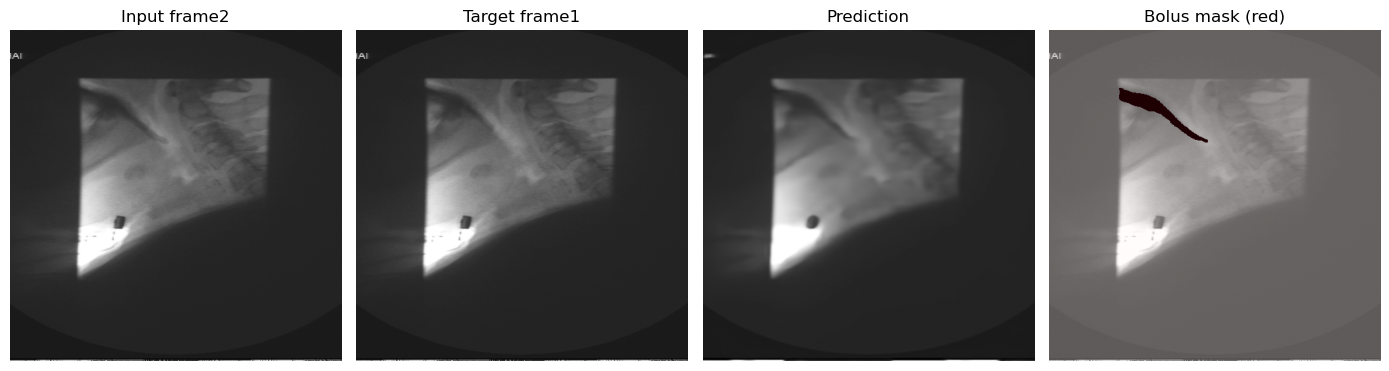

In [8]:
if best_state is not None:
    model.load_state_dict(best_state)
    model.to(device)

model.eval()
test_losses = []
test_psnr = []
with torch.no_grad():
    for frame2, frame1, mask1 in data_loaders["test"]:
        frame2, frame1, mask1 = [t.to(device) for t in (frame2, frame1, mask1)]
        pred = model(frame2)
        loss = masked_l1_loss(pred, frame1, mask1)
        mse = masked_mse(pred, frame1, mask1)
        test_losses.append(loss.item())
        test_psnr.append(psnr_from_mse(mse).item())

print(
    f"Test masked L1: {float(np.mean(test_losses)) if test_losses else float('nan'):.4f} | "
    f"Test PSNR: {float(np.mean(test_psnr)) if test_psnr else float('nan'):.2f}"
)

# quick qualitative sample (uses test split when available)
target_loader = data_loaders["test"] if len(splits["test"]) else data_loaders["val"]
with torch.no_grad():
    sample_batch = next(iter(target_loader))
    frame2, frame1, mask1 = [t.to(device) for t in sample_batch]
    pred = model(frame2).cpu().numpy()
    frame2 = frame2.cpu().numpy()
    frame1 = frame1.cpu().numpy()
    mask1 = mask1.cpu().numpy()

idx = 0
fig, axes = plt.subplots(1, 4, figsize=(14, 4))
axes[0].imshow(frame2[idx, 0], cmap="gray")
axes[0].set_title("Input frame2")
axes[1].imshow(frame1[idx, 0], cmap="gray")
axes[1].set_title("Target frame1")
axes[2].imshow(pred[idx, 0], cmap="gray", vmin=0, vmax=1)
axes[2].set_title("Prediction")
axes[3].imshow(frame1[idx, 0] * (1 - mask1[idx, 0]), cmap="gray")
axes[3].imshow(mask1[idx, 0], cmap="Reds", alpha=0.3)
axes[3].set_title("Bolus mask (red)")
for ax in axes:
    ax.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'vit_clean_weights.pth')


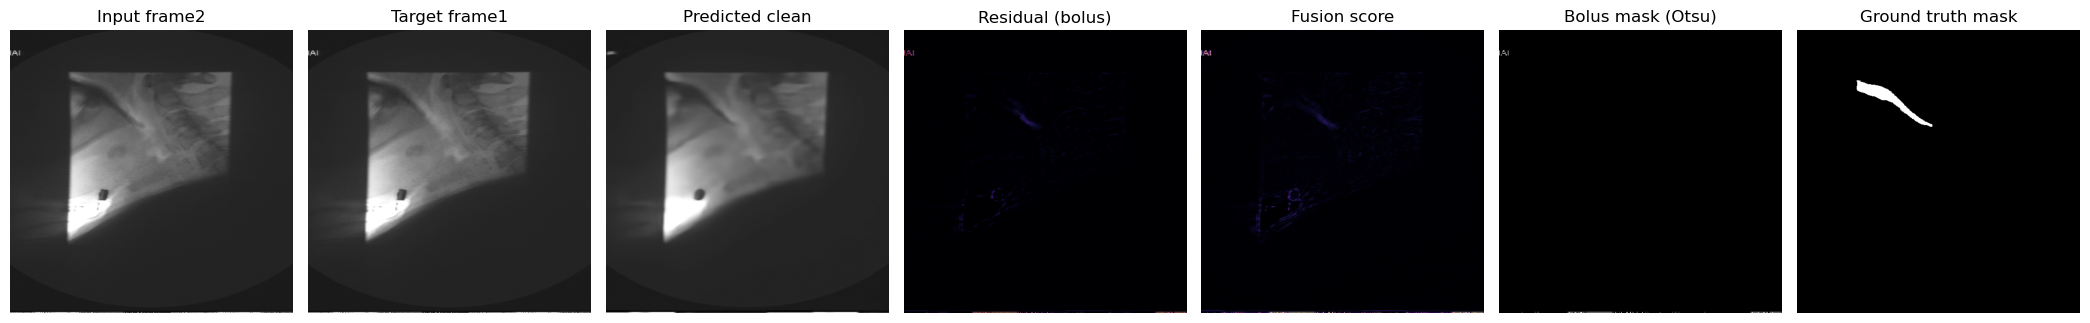

In [ ]:
# Load saved clean-frame weights and estimate bolus mask via frame fusion
CKPT_PATH = Path('vit_clean_weights.pth')

if not CKPT_PATH.exists():
    raise FileNotFoundError(f"Checkpoint not found: {CKPT_PATH}")

state = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(state)
model.to(device)
model.eval()

# prefer test loader if available
target_loader = data_loaders['test'] if len(splits['test']) else data_loaders['val']
with torch.no_grad():
    frame2, frame1, mask1 = [t.to(device) for t in next(iter(target_loader))]
    pred_clean = model(frame2).clamp(0, 1)
    residual = (frame1 - pred_clean).clamp(min=0)  # expected bolus contribution
    fusion = (residual + (frame2 - pred_clean).abs()).clamp(0, 1)

idx = 0
res_img = (residual[idx, 0].cpu().numpy() * 255).astype(np.uint8)
_, bolus_mask = cv2.threshold(res_img, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

fig, axes = plt.subplots(1, 7, figsize=(21, 4))
axes[0].imshow(frame2[idx, 0].cpu(), cmap='gray'); axes[0].set_title('Input frame2')
axes[1].imshow(frame1[idx, 0].cpu(), cmap='gray'); axes[1].set_title('Target frame1')
axes[2].imshow(pred_clean[idx, 0].cpu(), cmap='gray', vmin=0, vmax=1); axes[2].set_title('Predicted clean')
axes[3].imshow(residual[idx, 0].cpu(), cmap='magma'); axes[3].set_title('Residual (bolus)')
axes[4].imshow(fusion[idx, 0].cpu(), cmap='magma'); axes[4].set_title('Fusion score')
axes[5].imshow(bolus_mask, cmap='gray'); axes[5].set_title('Bolus mask (Otsu)')
axes[6].imshow(mask1[idx, 0].cpu(), cmap='gray'); axes[6].set_title('Ground truth mask')
for ax in axes: ax.axis('off')
plt.tight_layout()
plt.show()


Fusion params: 0.23M


[Attn] Epoch 1:   0%|          | 0/1191 [00:00<?, ?it/s]

[Attn] Epoch 1 BCE: 0.2717 | Dice: 0.2105


[Attn] Epoch 2:   0%|          | 0/1191 [00:00<?, ?it/s]

[Attn] Epoch 2 BCE: 0.2073 | Dice: 0.3373


[Attn] Epoch 3:   0%|          | 0/1191 [00:00<?, ?it/s]

[Attn] Epoch 3 BCE: 0.1906 | Dice: 0.2273


[Attn] Epoch 4:   0%|          | 0/1191 [00:00<?, ?it/s]

[Attn] Epoch 4 BCE: 0.1780 | Dice: 0.2030


[Attn] Epoch 5:   0%|          | 0/1191 [00:00<?, ?it/s]

[Attn] Epoch 5 BCE: 0.1688 | Dice: 0.3932


[Attn] Epoch 6:   0%|          | 0/1191 [00:00<?, ?it/s]

[Attn] Epoch 6 BCE: 0.1603 | Dice: 1.0000


[Attn] Epoch 7:   0%|          | 0/1191 [00:00<?, ?it/s]

[Attn] Epoch 7 BCE: 0.1543 | Dice: 0.1241


[Attn] Epoch 8:   0%|          | 0/1191 [00:00<?, ?it/s]

[Attn] Epoch 8 BCE: 0.1505 | Dice: 0.0758


[Attn] Epoch 9:   0%|          | 0/1191 [00:00<?, ?it/s]

[Attn] Epoch 9 BCE: 0.1457 | Dice: 0.1199


[Attn] Epoch 10:   0%|          | 0/1191 [00:00<?, ?it/s]

[Attn] Epoch 10 BCE: 0.1430 | Dice: 0.0901


[Attn] Epoch 11:   0%|          | 0/1191 [00:00<?, ?it/s]

[Attn] Epoch 11 BCE: 0.1393 | Dice: 0.1147


[Attn] Epoch 12:   0%|          | 0/1191 [00:00<?, ?it/s]

[Attn] Epoch 12 BCE: 0.1388 | Dice: 0.1154


[Attn] Epoch 13:   0%|          | 0/1191 [00:00<?, ?it/s]

[Attn] Epoch 13 BCE: 0.1329 | Dice: 0.2795


[Attn] Epoch 14:   0%|          | 0/1191 [00:00<?, ?it/s]

[Attn] Epoch 14 BCE: 0.1311 | Dice: 0.3234


[Attn] Epoch 15:   0%|          | 0/1191 [00:00<?, ?it/s]

[Attn] Epoch 15 BCE: 0.1311 | Dice: 0.1107


[Attn] Epoch 16:   0%|          | 0/1191 [00:00<?, ?it/s]

[Attn] Epoch 16 BCE: 0.1289 | Dice: 0.1707


[Attn] Epoch 17:   0%|          | 0/1191 [00:00<?, ?it/s]

[Attn] Epoch 17 BCE: 0.1244 | Dice: 0.1380


[Attn] Epoch 18:   0%|          | 0/1191 [00:00<?, ?it/s]

[Attn] Epoch 18 BCE: 0.1220 | Dice: 0.1525


[Attn] Epoch 19:   0%|          | 0/1191 [00:00<?, ?it/s]

[Attn] Epoch 19 BCE: 0.1226 | Dice: 0.1309


[Attn] Epoch 20:   0%|          | 0/1191 [00:00<?, ?it/s]

[Attn] Epoch 20 BCE: 0.1193 | Dice: 0.0836


[Attn] Epoch 21:   0%|          | 0/1191 [00:00<?, ?it/s]

[Attn] Epoch 21 BCE: 0.1198 | Dice: 0.0990


[Attn] Epoch 22:   0%|          | 0/1191 [00:00<?, ?it/s]

[Attn] Epoch 22 BCE: 0.1178 | Dice: 0.2447


[Attn] Epoch 23:   0%|          | 0/1191 [00:00<?, ?it/s]

[Attn] Epoch 23 BCE: 0.1161 | Dice: 0.1157


[Attn] Epoch 24:   0%|          | 0/1191 [00:00<?, ?it/s]

[Attn] Epoch 24 BCE: 0.1142 | Dice: 0.2284


[Attn] Epoch 25:   0%|          | 0/1191 [00:00<?, ?it/s]

[Attn] Epoch 25 BCE: 0.1133 | Dice: 0.1085


[Attn] Epoch 26:   0%|          | 0/1191 [00:00<?, ?it/s]

[Attn] Epoch 26 BCE: 0.1123 | Dice: 0.3246


[Attn] Epoch 27:   0%|          | 0/1191 [00:00<?, ?it/s]

[Attn] Epoch 27 BCE: 0.1118 | Dice: 0.1255


[Attn] Epoch 28:   0%|          | 0/1191 [00:00<?, ?it/s]

[Attn] Epoch 28 BCE: 0.1102 | Dice: 0.1712


[Attn] Epoch 29:   0%|          | 0/1191 [00:00<?, ?it/s]

[Attn] Epoch 29 BCE: 0.1076 | Dice: 0.2537


[Attn] Epoch 30:   0%|          | 0/1191 [00:00<?, ?it/s]

[Attn] Epoch 30 BCE: 0.1081 | Dice: 0.1012


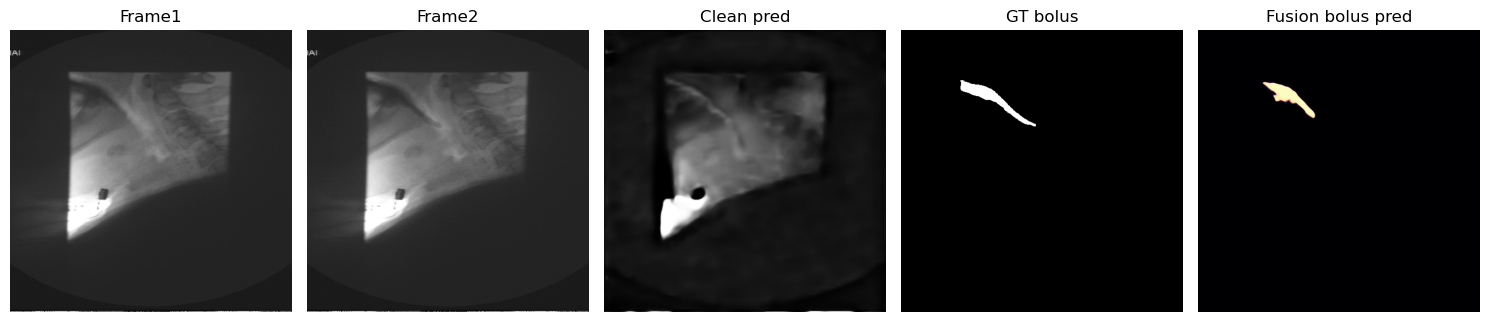

In [ ]:
# Fusion bolus model: frame1 + clean prediction -> bolus mask (joint fine-tuning)
ATTN_EPOCHS = 30  # increase for better results
ATTN_LR = 1e-3
CLEAN_LR = 1e-4  # smaller LR for the clean frame model when unfrozen
DICE_WEIGHT = 0.5  # blend BCE + Dice

# fresh fusion head for this stage
fusion_model = FusionBolusViT(
    in_ch=2,
    base=FUSION_BASE,
    heads=FUSION_HEADS,
    win=FUSION_WIN,
    blocks=FUSION_BLOCKS,
).to(device)
attn_model = fusion_model

attn_optimizer = torch.optim.Adam(
    [
        {'params': attn_model.parameters(), 'lr': ATTN_LR},
        {'params': model.parameters(), 'lr': CLEAN_LR},
    ]
)
bce_loss = nn.BCELoss()

def dice_loss_binary(prob, target, eps: float = 1e-6):
    # prob, target: [B,1,H,W]
    inter = (prob * target).sum(dim=(1, 2, 3))
    denom = prob.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3))
    dice = (2 * inter + eps) / (denom + eps)
    return 1 - dice.mean()

print(f"Fusion params: {count_params(attn_model)/1e6:.2f}M")

for epoch in range(1, ATTN_EPOCHS + 1):
    model.train()
    attn_model.train()
    losses = []
    progress = tqdm(data_loaders['train'], desc=f"[Attn] Epoch {epoch}", leave=False)
    for frame2, frame1, mask1 in progress:
        frame2, frame1, mask1 = [t.to(device) for t in (frame2, frame1, mask1)]
        clean_pred = model(frame2).clamp(0, 1)
        fused = torch.cat([frame1, clean_pred], dim=1)
        prob = attn_model(fused).clamp(0, 1)

        loss_bce = bce_loss(prob, mask1)
        loss_dice = dice_loss_binary(prob, mask1)
        loss = loss_bce + DICE_WEIGHT * loss_dice

        attn_optimizer.zero_grad()
        loss.backward()
        attn_optimizer.step()
        losses.append(loss.item())
        progress.set_postfix(loss=f"{loss.item():.4f}")
    print(f"[Attn] Epoch {epoch} BCE: {float(np.mean(losses)):.4f} | Dice: {loss_dice.item():.4f}")

# quick eval/visualization
model.eval()
attn_model.eval()
target_loader = data_loaders['test'] if len(splits['test']) else data_loaders['val']
with torch.no_grad():
    frame2, frame1, mask1 = [t.to(device) for t in next(iter(target_loader))]
    clean_pred = model(frame2).clamp(0, 1)
    fused = torch.cat([frame1, clean_pred], dim=1)
    bolus_pred = attn_model(fused)

idx = 0
fig, axes = plt.subplots(1, 5, figsize=(15, 4))
axes[0].imshow(frame1[idx, 0].cpu(), cmap='gray'); axes[0].set_title('Frame1')
axes[1].imshow(frame2[idx, 0].cpu(), cmap='gray'); axes[1].set_title('Frame2')
axes[2].imshow(clean_pred[idx, 0].cpu(), cmap='gray', vmin=0, vmax=1); axes[2].set_title('Clean pred')
axes[3].imshow(mask1[idx, 0].cpu(), cmap='gray'); axes[3].set_title('GT bolus')
axes[4].imshow(bolus_pred[idx, 0].cpu(), cmap='magma', vmin=0, vmax=1); axes[4].set_title('Fusion bolus pred')
for ax in axes: ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
torch.save(attn_model.state_dict(), 'vit_fusion_weights.pth')


In [13]:
# Evaluate attention bolus model: IoU, Dice (DSC), AUC
from sklearn.metrics import roc_auc_score

attn_model.eval()
target_loader = data_loaders["test"] if len(splits["test"]) else data_loaders["val"]

total_iou = []
total_dice = []
all_probs = []
all_targets = []

with torch.no_grad():
    for frame2, frame1, mask1 in target_loader:
        frame2, frame1, mask1 = [t.to(device) for t in (frame2, frame1, mask1)]
        clean_pred = model(frame2).clamp(0, 1)
        fused = torch.cat([frame1, clean_pred], dim=1)
        bolus_pred = attn_model(fused).clamp(0, 1)

        pred_bin = (bolus_pred >= 0.5).float()
        intersection = (pred_bin * mask1).sum(dim=(1, 2, 3))
        union = pred_bin.sum(dim=(1, 2, 3)) + mask1.sum(dim=(1, 2, 3)) - intersection
        dice = (2 * intersection) / (pred_bin.sum(dim=(1, 2, 3)) + mask1.sum(dim=(1, 2, 3))).clamp_min(1e-6)
        iou = intersection / union.clamp_min(1e-6)

        total_iou.extend(iou.cpu().numpy().tolist())
        total_dice.extend(dice.cpu().numpy().tolist())
        all_probs.append(bolus_pred.cpu().numpy().reshape(-1))
        all_targets.append(mask1.cpu().numpy().reshape(-1))

all_probs = np.concatenate(all_probs) if all_probs else np.array([])
all_targets = np.concatenate(all_targets) if all_targets else np.array([])

if all_probs.size == 0:
    auc = float("nan")
elif np.unique(all_targets).size < 2:
    auc = float("nan")
else:
    auc = roc_auc_score(all_targets, all_probs)

print(
    f"Attn IoU: {float(np.mean(total_iou)) if total_iou else float('nan'):.4f} | "
    f"Attn Dice: {float(np.mean(total_dice)) if total_dice else float('nan'):.4f} | "
    f"Attn AUC: {auc if not np.isnan(auc) else float('nan'):.4f}"
)


Attn IoU: 0.4855 | Attn Dice: 0.6087 | Attn AUC: 0.9875
